In [523]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from crop_image import *
import imutils
from imutils import contours as imcnts
import skimage.io as io
from skimage.exposure import histogram
from bubble_sheet_answer import *
from paper_extraction import *
%matplotlib inline

In [524]:
image = cv2.imread('omr.png')
cv2.imshow('omr.png',image)
cv2.waitKey(0)

-1

In [525]:
gray_scale = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
cv2.imshow('gray scale image.jpg',gray_scale)
cv2.waitKey(0)

-1

In [526]:
"""gaussian = cv2.GaussianBlur(image,(3,3),0)
cv2.imshow('image',gaussian)
cv2.waitKey(0)"""

"gaussian = cv2.GaussianBlur(image,(3,3),0)\ncv2.imshow('image',gaussian)\ncv2.waitKey(0)"

In [527]:
edged = cv2.Canny(gray_scale,50,200)
# cv2.imshow('edged.jpg',edged)
# cv2.waitKey(0)

In [528]:
contours,_= cv2.findContours(edged, 
    cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

print("Number of Contours found = " + str(len(contours)))
  
cv2.drawContours(image, contours, -1,(0,255,0), 3)
  
# cv2.imshow('Contours.jpg', image)
# cv2.waitKey(0)
image = cv2.imread('omr.png')

Number of Contours found = 4


In [529]:
#sorting all contours
if(len(contours)>0):
    contours=sorted(contours,key=cv2.contourArea,reverse=True)

In [530]:
cv2.drawContours(image, contours, 0,(0,255,0), 3)
  
# cv2.imshow('Contours3.jpg', image)
# cv2.waitKey(0)
image = cv2.imread('omr.png')

In [531]:
paper_contour=None
for cnt in contours:
    peri = cv2.arcLength(cnt,True)
    print(peri)
    # to approximate the given shape to polygon (high value leads to underestimation and low value leads to overestimation)
    ratio=0.02
    approx=cv2.approxPolyDP(cnt,ratio*peri,True)
    cv2.drawContours(image, [approx], 0,(0,0,255), 3)
    print(len(approx))
    coordinates=approx.ravel()
    for i in range(0,len(coordinates),2):
        x=coordinates[i]
        y=coordinates[i+1]
        cv2.putText(image, "vertex"+str(i//2), (x, y),cv2.FONT_HERSHEY_COMPLEX, 0.5, (255, 0, 0)) 
    if(len(approx)==4):
        paper_contour=approx
        break
# cv2.imshow('Contours2.jpg', image)
# cv2.waitKey(0)
image = cv2.imread('omr.png')

1906.0
4


In [532]:
print(paper_contour.shape)

(4, 1, 2)


In [533]:
paper= four_point_transform(image, paper_contour.reshape(4, 2))  
cv2.imshow('paper', paper)
cv2.waitKey(0)

-1

In [534]:
gray_scale_paper= four_point_transform(gray_scale, paper_contour.reshape(4, 2))  
gray_scale_paper= four_point_transform(gray_scale_paper, paper_contour.reshape(4, 2))  
cv2.imshow('paper', gray_scale_paper)
cv2.waitKey(0)

-1

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

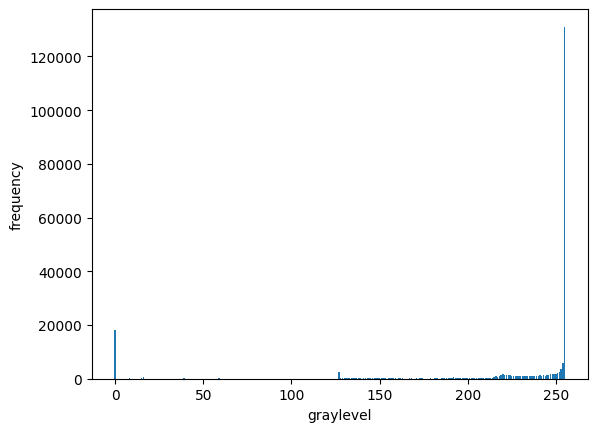

In [535]:
hist, bin_centers = histogram(gray_scale_paper,20)
print(bin_centers)
plt.figure()
plt.bar(bin_centers, hist, width=0.8, align='center')
plt.xlabel("graylevel")
plt.ylabel("frequency")
plt.show()

In [536]:
image = cv2.imread('omr.png')
cv2.imshow('omr.png',image)
cv2.waitKey(0)
gray_scale_paper=extract_the_paper_from_image(image)
gray_scale_paper=extract_the_paper_from_image(gray_scale_paper)
gray_scale_paper = cv2.cvtColor(gray_scale_paper,cv2.COLOR_BGR2GRAY)
cv2.imshow('gray scale image.jpg',gray_scale)
cv2.waitKey(0)

-1

In [537]:
_,thresholded=cv2.threshold(gray_scale_paper,230,255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
cv2.imshow('paper1', thresholded)
cv2.waitKey(0)

-1

In [538]:
# _,thresholded=cv2.threshold(gray_scale_paper,150,255, cv2.THRESH_BINARY_INV)
# cv2.imshow('paper2', thresholded)
# cv2.waitKey(0)

In [539]:
pap_cnts,_=cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

In [540]:
def test_cnts(cnts):
    cv2.drawContours(thresholded, cnts, -1,255, 3)
  
    cv2.imshow('Contours.jpg', thresholded)
    cv2.waitKey(0)

In [541]:
pre_question_cnts=[]
value=(15,50)
i=0
for cnt in pap_cnts:
    (x,y,w,h)=cv2.boundingRect(cnt)
    aspect_ratio=w/h
    if(w>=value[0] and w<=value[1] and h>=value[0] and h<=value[1] and aspect_ratio>=0.9 and aspect_ratio<=1.1):
        pre_question_cnts.append(cnt)

In [542]:
print(len(pre_question_cnts),len(pap_cnts))

0 0


In [543]:
if(len(pre_question_cnts)!=0):
    question_cnts,_=imcnts.sort_contours(pre_question_cnts,method='top-to-bottom')
    xs_set=set()
    i=0

    for cnt in question_cnts:
        (x,y,w,h)=cv2.boundingRect(cnt)
        if(all([ x-i not in xs_set and x+i not in xs_set for i in np.arange(0,5)])):
            xs_set.add(x)
    number_of_bubbles=len(xs_set)
    print(xs_set)
    print("number of bubbles : "+str(number_of_bubbles))
    xs=np.array(list(sorted(xs_set)))
    dist=np.append(xs[1:],xs[-1])-xs
    print("differences:" ,dist)
    distance_set=[]
    for diff in dist:
        if(len(distance_set)==0 or all([ diff-i != distance_set[-1] and diff+i != distance_set[-1] for i in np.arange(0,5)])):
            distance_set.append(diff)
    print(len(distance_set))
    distance_set.pop()
    print(distance_set)
    print(distance_set[1:4])
    #distance_set=[1,1]
    #print("print func",)
    number_of_columns=sum([x > distance_set[i] and x > distance_set[i+2] for i, x in enumerate(distance_set[1:-1])])+1
    number_of_choices=number_of_bubbles//number_of_columns
    print(number_of_choices,number_of_columns)

In [544]:
tt=[i>2 for i in np.arange(1,5)]
print(all(tt))

False


In [545]:
# Answer_key= {0:1, 1:4, 2:0, 3:2}
# correct=0
# flag=False
# cv2.drawContours(paper,question_cnts,0,(255,0,0), 1)
# cv2.imshow('hgsvrgvj',paper)
# cv2.waitKey(0)
# cnt=question_cnts[0]
# peri = cv2.arcLength(cnt,True)
# #print(peri)
# # to approximate the given shape to polygon (high value leads to underestimation and low value leads to overestimation)
# ratio=0.00005
# approx=cv2.approxPolyDP(cnt,ratio*peri,True)
# (x,y,w,h)=cv2.boundingRect(cnt)
# aspect_ratio=w/h
# print(len(approx))
# paper= four_point_transform(image, paper_contour.reshape(4, 2))  

In [546]:
print(len(question_cnts))

4


In [547]:
#test_cnts(question_cnts)

In [548]:
# _,thresholded=cv2.threshold(gray_scale_paper,150,255, cv2.THRESH_BINARY_INV)
# pap_cnts,_=cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

In [549]:
colors=[(255,0,0)
,(0,255,0)
,(0,0,255)
,(0,255,255)
,(255,255,0)
,(0,0,255)
,(0,255,255)
,(255,0,255)
,(192,192,192)
,(128,128,128)
,(128,0,0)
,(128,128,0)
,(0,128,0)
,(128,0,128)
,(0,128,128)
,(0,0,128),
       (255,215,0)]

In [550]:
counter=0
qs=0
for (row,i) in enumerate(np.arange(0,len(question_cnts),number_of_columns*number_of_choices)):

    curr_row_cnts,_=imcnts.sort_contours(question_cnts[i:i+number_of_columns*number_of_choices])
    for k in np.arange(0,len(curr_row_cnts),number_of_choices):
        curr_ques_cnts=curr_row_cnts[k:k+number_of_choices]
        color1=colors[qs%len(colors)]
        cv2.drawContours(gray_scale_paper,curr_ques_cnts,-1,color1, 1)
        bubbled=None
        for (j,c) in enumerate(curr_ques_cnts):
            mask = np.zeros(thresholded.shape, dtype="uint8")
            #negative one at the last arguement to fill the contours
            cv2.drawContours(mask, [c], -1, 255, -1)
            mask= cv2.bitwise_and(thresholded, mask)
            total= cv2.countNonZero(mask)

            if bubbled is None or total >bubbled[0]:
                bubbled= (total, j)
            color= (0, 0, 255)
        print(f"qestion#{qs+1}: {chr(bubbled[1]+ord('A'))}")
        qs+=1
    counter+=1
print(counter)
counter=0
cv2.imshow('paper', gray_scale_paper)
cv2.waitKey(0)
paper= four_point_transform(image, paper_contour.reshape(4, 2)) 

qestion#1: A
qestion#2: A
2


In [551]:
for i,cnt in enumerate(question_cnts):
    color1=(255,0,0) if i%2==0 else (0,0,255)
    cv2.drawContours(paper,[cnt],-1,color1, 1)
# cv2.imshow('paper', paper)
# cv2.waitKey(0)
paper= four_point_transform(image, paper_contour.reshape(4, 2)) 

In [552]:
def show_images(images,titles=None):
    #This function is used to show image(s) with titles by sending an array of images and an array of associated titles.
    # images[0] will be drawn with the title titles[0] if exists
    # You aren't required to understand this function, use it as-is.
    n_ims = len(images)
    if titles is None: titles = ['(%d)' % i for i in range(1,n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image,title in zip(images,titles):
        a = fig.add_subplot(1,n_ims,n)
        if image.ndim == 2: 
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
    plt.show()



In [553]:
print(contours)

[array([[[24, 13]],

       [[24, 14]],

       [[24, 15]],

       ...,

       [[27, 13]],

       [[26, 13]],

       [[25, 13]]], dtype=int32), array([[[ 24, 566]],

       [[ 25, 566]],

       [[ 26, 566]],

       ...,

       [[ 27, 566]],

       [[ 26, 566]],

       [[ 25, 566]]], dtype=int32), array([[[428,  13]],

       [[428,  14]],

       [[428,  15]],

       ...,

       [[428,  16]],

       [[428,  15]],

       [[428,  14]]], dtype=int32), array([[[23, 11]],

       [[22, 12]],

       [[22, 13]],

       ...,

       [[26, 11]],

       [[25, 11]],

       [[24, 11]]], dtype=int32)]


In [554]:
f"adham{chr(bubbled[1]+ord('A'))}"

'adhamA'